Hurst exponent , kauffman efficiency and ADF test

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [28]:
from curl_cffi import requests

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('AMT', session=session)
risk_free = yf.Ticker('^GSPC', session=session)

# Set time horizon using the `period` or `start`/`end` arguments
amt_data = ticker.history(period="1y")  # Last 1 year
sp500_data = risk_free.history(start="2023-01-01", end="2024-01-01")  # Custom range
return_df= amt_data[['Close']].reset_index()
return_df.columns = ['Date', 'Close']
riskfree_df = sp500_data[['Close']].reset_index()
riskfree_df.columns = ['Date', 'Close']

return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m-%d')
return_df.head()
riskfree_df['Date'] = pd.to_datetime(riskfree_df['Date'])
riskfree_df['Date'] = riskfree_df['Date'].dt.strftime('%Y-%m-%d')

return_df.head()
riskfree_df.head()

,Date,Close
0,2023-01-03,3824.139893
1,2023-01-04,3852.969971
2,2023-01-05,3808.100098
3,2023-01-06,3895.080078
4,2023-01-09,3892.090088


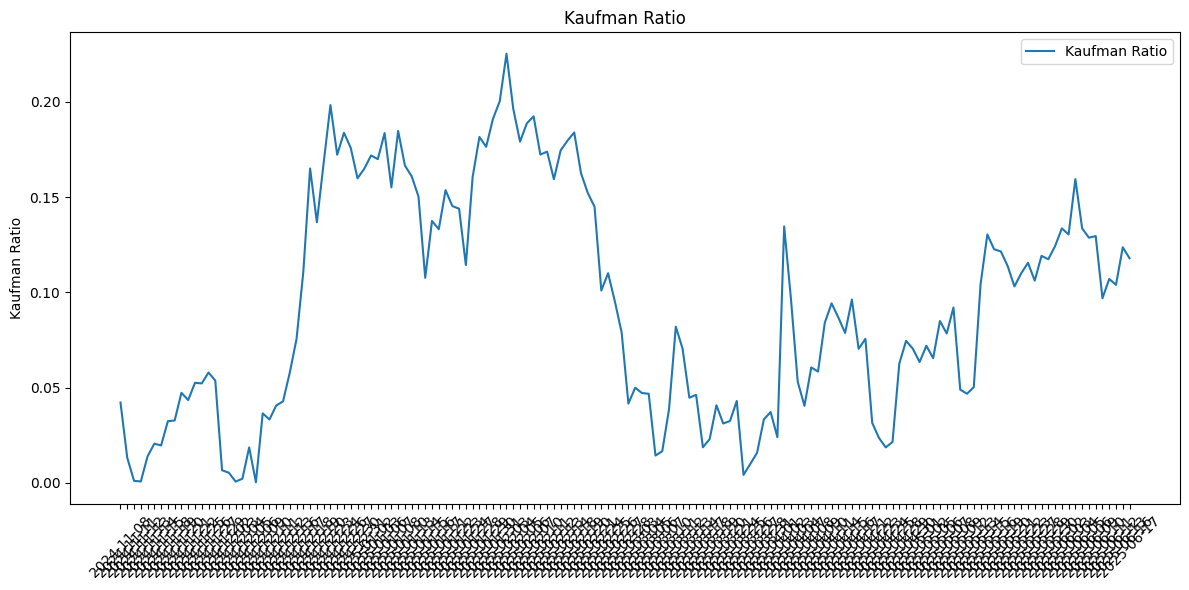

In [3]:
returns = return_df['Close'].pct_change().dropna()
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
return_df = return_df.dropna(subset=['Log_Return'])

def kaufman_ratio(prices, window = 100):
    signal = prices.diff(window).abs()
    noise = prices.diff().abs().rolling(window).sum()

    er = signal / noise
    return er

return_df['kaufman'] = kaufman_ratio(return_df['Close'], window=100)
return_df = return_df.dropna(subset=['kaufman'])

#plot return_df['kaufman'])
plt.figure(figsize=(12, 6))
plt.plot(return_df['Date'], return_df['kaufman'], label='Kaufman Ratio')
plt.title('Kaufman Ratio')
plt.ylabel('Kaufman Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
return_df = return_df.dropna(subset=['kaufman'])
return_df['kaufman'].head()

101    0.042215
102    0.013197
103    0.001098
104    0.000746
105    0.013966
Name: kaufman, dtype: float64

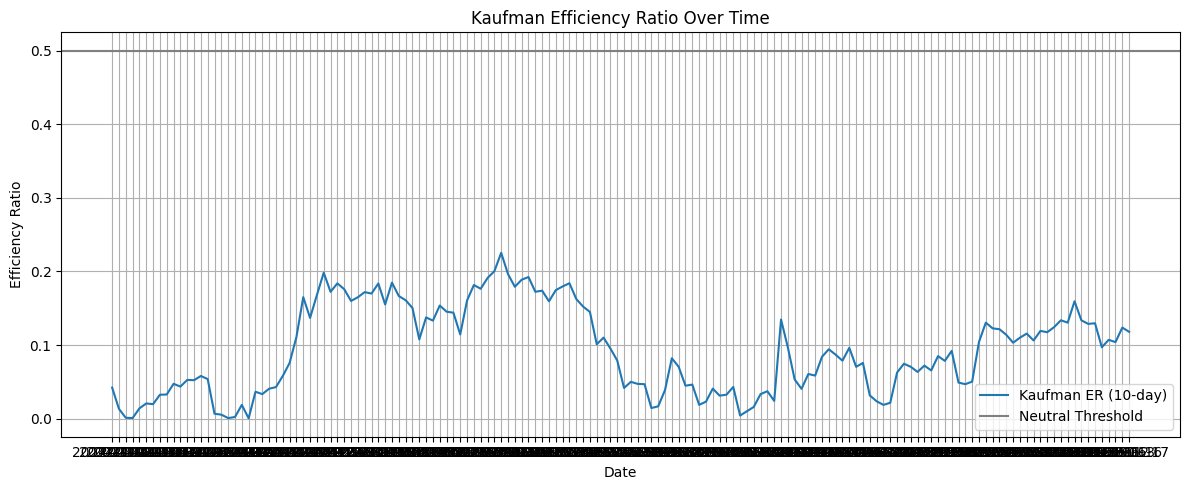

In [5]:
plt.figure(figsize=(12,5))
plt.plot(return_df['Date'], return_df['kaufman'], label='Kaufman ER (10-day)')
plt.axhline(0.5, color='gray', label='Neutral Threshold')
plt.title('Kaufman Efficiency Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Efficiency Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
series = return_df['Log_Return'].dropna() #initialise series
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

#hurst exponent calculation , used lag values

def hurst_exponent(ts, max_lag= 150):
    lags = range(2,max_lag)
    
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags] #calculating variance Xt - Xt-lag
    
    lags = np.array(lags)  # Convert lags to a NumPy array
    tau = np.array(tau)    # Convert tau to a NumPy array
    poly = np.polyfit(np.log(lags), np.log(tau), 1)  # Apply log correctly
    return poly[0]*2.0 #log^2H

from math import log
hurst = hurst_exponent(return_df['Log_Return'].dropna().values)
print("Hurst Exponent:", hurst)

ADF Statistic: -15.918417814321973
p-value: 7.975130845920518e-29
Critical Values: {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}
Hurst Exponent: -0.01031044164386585


In [29]:
def hurst_rs(ts, min_window=10, max_window=100):
    N = len(ts)
    H_vals = []

    for window in range(min_window, max_window):
        if window >= N:
            break
        n_chunks = N // window
        R_S = []

        for i in range(n_chunks):
            chunk = ts[i * window : (i + 1) * window]
            mean = np.mean(chunk)
            dev = chunk - mean
            Z = np.cumsum(dev)
            R = np.max(Z) - np.min(Z)
            S = np.std(chunk)

            if S > 0:
                R_S.append(R / S)

        if len(R_S) > 0:
            H_vals.append((np.log(window), np.log(np.mean(R_S))))

    if len(H_vals) < 2:
        return np.nan

    log_window, log_RS = zip(*H_vals)
    slope, _ = np.polyfit(log_window, log_RS, 1)
    return slope

log_ts = np.log(return_df['Close'].dropna().values)
hurst = hurst_rs(log_ts)
print("Hurst Exponent (R/S method):", hurst)
# Get mean reversion speed
def mean_reversion_speed(series):
    return np.mean(np.diff(series))
mean_reversion = mean_reversion_speed(return_df['Log_Return'].dropna())
print("Mean Reversion Speed:", mean_reversion)


Hurst Exponent (R/S method): 0.9996328260277928


KeyError: 'Log_Return'

Value at Risk (95% confidence level) using Log Returns: -0.0280


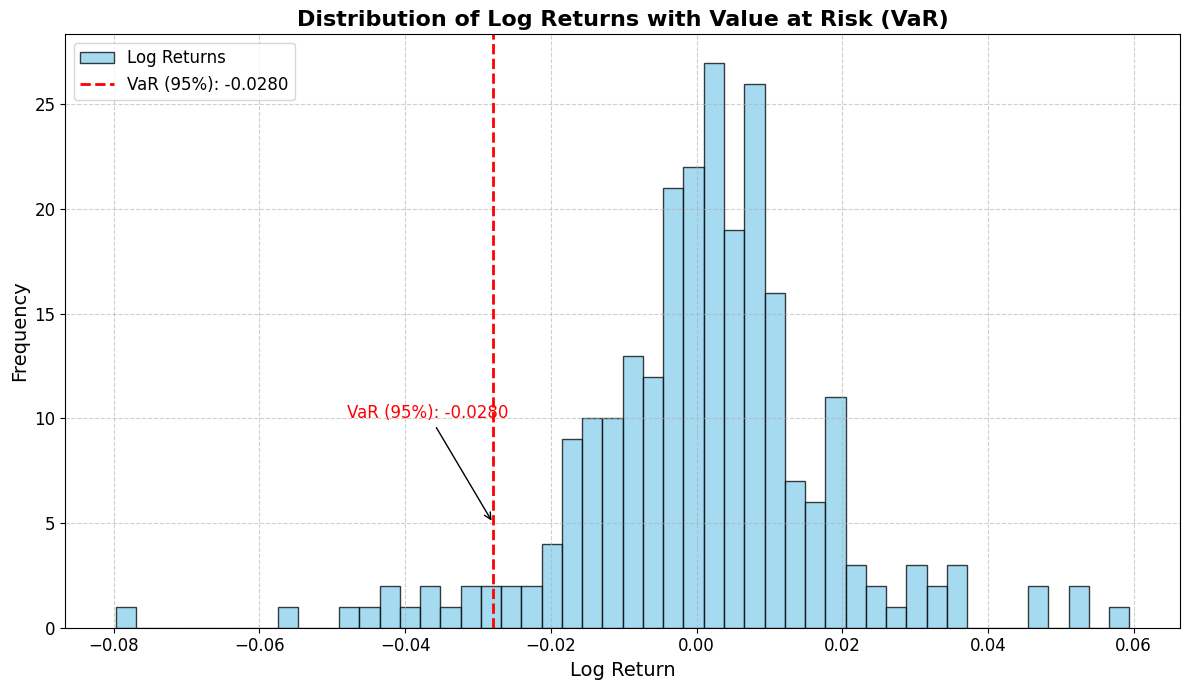

In [30]:
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1)).dropna()

confidence_level = 0.95

VaR_95_log = np.percentile(return_df['Log_Return'].dropna(), (1 - confidence_level) * 100)

print(f"Value at Risk (95% confidence level) using Log Returns: {VaR_95_log:.4f}")

# Enhanced plot
plt.figure(figsize=(12, 7))
plt.hist(return_df['Log_Return'], bins=50, alpha=0.75, color='skyblue', edgecolor='black', label='Log Returns')
plt.axvline(VaR_95_log, color='red', linestyle='dashed', linewidth=2, label=f'VaR (95%): {VaR_95_log:.4f}')

# Add grid, title, and labels
plt.title('Distribution of Log Returns with Value at Risk (VaR)', fontsize=16, fontweight='bold')
plt.xlabel('Log Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Add annotation for VaR
plt.annotate(f'VaR (95%): {VaR_95_log:.4f}', 
             xy=(VaR_95_log, 5), 
             xytext=(VaR_95_log - 0.02, 10), 
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=12, color='red')

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
# get expected return percentage and probability of return assigning a holding period
def expected_return(returns, holding_period=60):
    mean_return = returns.mean()
    std_dev = returns.std()
    return mean_return * holding_period, std_dev * np.sqrt(holding_period) #expected return given holding period
def probability_of_return(returns, threshold=0.01):
    return np.mean(returns > threshold)
holding_period = 100  # 1 day
expected_return_value, expected_std_dev = expected_return(return_df['Log_Return'].dropna(), holding_period)
print(f"Expected Return: {expected_return_value:.4f}, Expected Std Dev: {expected_std_dev:.4f}")
probability = probability_of_return(return_df['Log_Return'].dropna(), threshold=0.01)
print(f"Probability of Return > 1%: {probability:.4f}")



Expected Return: 0.0652, Expected Std Dev: 0.1723
Probability of Return > 1%: 0.2088


/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_1177/2130910643.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


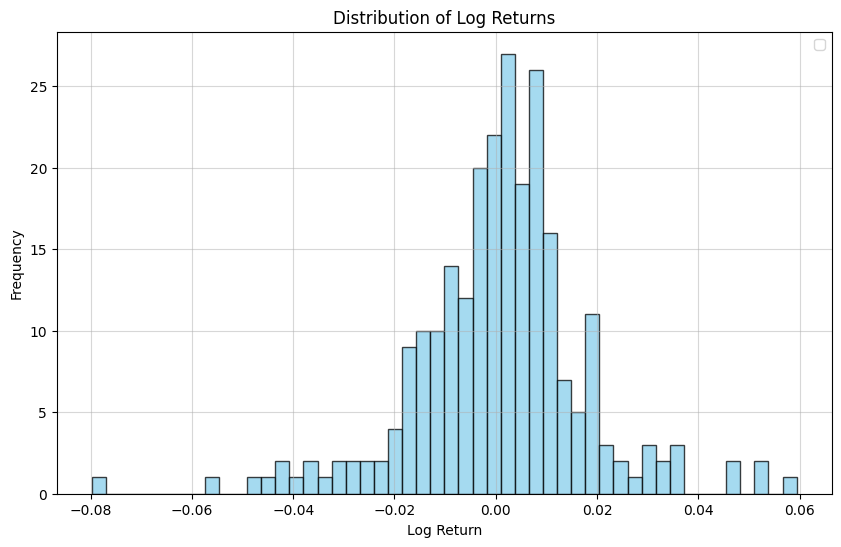

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(return_df['Log_Return'].dropna(), bins=50, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [32]:
# win rate probability
def win_rate(returns):
    return np.mean(returns > returns.mean())
win_rate_value = win_rate(return_df['Log_Return'].dropna())
print(f"Win Rate: {win_rate_value:.4f}")

Win Rate: 0.5400
